# Оглавление

1. [Введение. Описание проекта](#description)
2. [Описание исследования](#description_1)
3. [Изучение поведения пользователей. Анализ воронки продаж](#analysis)
4. [Изучение результатов эксперимента](#experiment)
5. [Выводы](#summary)


<a id="back_to_title"></a>

# Введение. Описание проекта
<a id="description"></a>

На базе стартапа, который продаёт продукты питания, нужно разобраться, как ведут себя пользователи мобильного приложения. Изучим воронку продаж и узнаем, как пользователи доходят до покупки, сколько пользователей доходит до покупки, сколько — «застревает» на предыдущих шагах и на каких именно.
Далее исследуем результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Примем решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясним, какой шрифт лучше.

# Описание исследования
<a id="description_1"></a>

[К ОГЛАВЛЕНИЮ](#back_to_title)

В распоряжении 1 датасет, на базе которого будут проведены отдельные иследования:

I) Изучение поведения пользователей, анализ воронки продаж

**Цель исследования** - общее изучение этапов воронки продаж, понимание этапов, на которых пользователи «застревают» 

**Ход исследования** - Посмотрим, какие события есть в логах, как часто они встречаются. 
Посчитаем, сколько пользователей совершали каждое из этих событий. Посчитаем долю пользователей, которые хоть раз совершали событие.
По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). Определим, на каком шаге теряется больше всего пользователей. Расчитаем, какая доля пользователей доходит от первого события до оплаты.

II) Анализ А/A/B-теста.

**Цель исследования** — выяснить, наблюдаются ли статистически значимые различия в результатах теста между группами А и В.

**Ход исследования** - Анализ А/A/B теста будет выполнен в соответствии со следующей этапностью:

- Определение количества пользователей в каждой экспериментальной группе.
- Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверим, находят ли статистические критерии разницу между выборками 246 и 247.
- Выберем самое популярное событие. Посчитаем число пользователей, совершивших это событие в каждой из контрольных групп. Посчитаем долю пользователей, совершивших это событие. Проверим, будет ли отличие между группами статистически достоверным. 
- Проделаем то же самое для всех других событий. Проверим корректно ли работает разбиение на группы.
- Аналогично поступим с группой с изменённым шрифтом. Сравним результаты с каждой из контрольных групп в отдельности по каждому событию. Сравним результаты с объединённой контрольной группой. Сделем выводы из эксперимента?

# Изучение поведения пользователей. Анализ воронки продаж
<a id="analysis"></a>

[К ОГЛАВЛЕНИЮ](#back_to_title)

In [117]:
#импортируем все библиотеки, которые понадобятся в исследованиях
import pandas as pd
import math as mth
import datetime as dt
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import warnings
# конвертеры, которые позволяют использовать типы pandas в matplotlib  
register_matplotlib_converters()

In [118]:
data = pd.read_csv('/Users/tatanakondrahina/logs_exp.csv',sep = '\t')#знакомимся с датасетом
data.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


Выполним предобработку данных.

Переименуем столбцы таблицы, уберем заглавные буквы:

In [119]:
data.columns = ('event_name','device_id','event_date','group')
data.head()

,event_name,device_id,event_date,group
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


Проверим датасет на пропуски, дубликаты, типы данных.

In [120]:
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   event_name  244126 non-null  object
 1   device_id   244126 non-null  int64 
 2   event_date  244126 non-null  int64 
 3   group       244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [121]:
data['event_date']= pd.to_datetime(data['event_date'],unit="s") #поменяем тип данных столбца event_date на дату
data.head()

,event_name,device_id,event_date,group
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248


In [122]:
data.duplicated().sum() #считаем количество строк-дубликатов

413

In [123]:
data = data.drop_duplicates()#удаляем дубликаты

In [124]:
data.duplicated().sum()#проверяем удаление дубликатов

0

Добавим отдельный столбец дат:

In [125]:
data['date'] = pd.to_datetime(data['event_date']).dt.date
data.head()

,event_name,device_id,event_date,group,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


В ходе предобработки данных были переименованы колонки, данные изучены на пропущенные значения и дубликаты. Пропущенных значений не выявлено. Дубликаты выявлены и удалены. Колонка 'event_date' преведена к типу данных datetime. Из этой же колонки извлечена отдельно дата и создана новая колонка, содержащая только дату (без времени) 

Изучим и проверим данные. Для начала посмотрим, сколько всего событий в логе. 

In [126]:
data['event_name'].count() 

243713

В логе содержатся данные о 243 713 событиях.

Посмотрим, сколько всего пользователей в логе.

In [127]:
data['device_id'].nunique() 

7551

Количество уникальных пользователей в логе 7551

Расчитаем, сколько в среднем событий приходится на пользователя.

In [128]:
display(data['event_name'].count()/data['device_id'].nunique())

32.27559263673685

На одного пользователя в среднем приходится 32 события. 

Посмотрим, данными за какой период мы располагаем. Найдем максимальную и минимальную дату. 

In [129]:
data['date'].max()

datetime.date(2019, 8, 7)

In [130]:
data['date'].min()

datetime.date(2019, 7, 25)

Таким образом, в датасете охвачен период с 25 июля по 7 августа 2019 года.

Построим гистограмму по дате и времени, чтобы быть уверенными, что у нас одинаково полные данные за весь период. Если нужно, определим, с какого момента данные полные и отбросим более старые. 

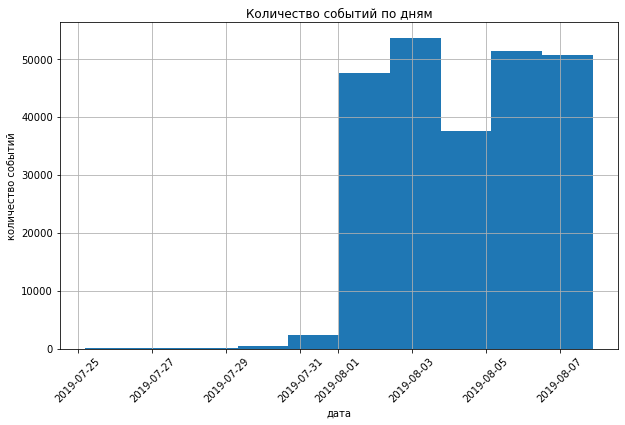

In [131]:
plt.figure (figsize=(10,6))
data['event_date'].hist()

plt.title('Количество событий по дням')
plt.xlabel('дата')
plt.ylabel('количество событий')
plt.xticks(rotation=45)
plt.show()
plt.show()

Данные до 1 августа кажутся подозрительными: их очень мало в каждый из дней. Они не относятся к нашему исследованию, отбросим их: 

In [132]:
data_new = data.query('event_date >= "2019-08-01"')
display(data_new['date'].min())
display(data_new['date'].max())

datetime.date(2019, 8, 1)

datetime.date(2019, 8, 7)

Теперь мы фактически располагаем данными за период с 1 по 7 августа 2019 года.

Посмотрим, много ли событий и пользователей мы потеряли, отбросив старые данные.

In [133]:
data_new['event_name'].count()*100/data['event_name'].count()-100

-1.1595606307418933

In [134]:
data_new['device_id'].nunique()*100/ data['device_id'].nunique()-100

-0.22513574361012445

Отбросив старые данные, мы потеряли 1,2% событий и 0,2% пользователей, что является вполне допустимым и не превышает 5%.

Проверим, что у нас есть пользователи из всех трёх экспериментальных групп.

In [135]:
data_new.groupby('group')['device_id'].count()

group
246    79302
247    77022
248    84563
Name: device_id, dtype: int64

В очищенном датасете есть пользователи из всех трёх экспериментальных групп.

Посмотрим, какие события есть в логах, как часто они встречаются. 

In [136]:
data_new.groupby('event_name')['event_name'].count().sort_values(ascending=False)

event_name
MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

В логах есть следующие события (в порядке убывания встречаемости): 
 1) MainScreenAppear, 2) OffersScreenAppear , 3) CartScreenAppear, 4) PaymentScreenSuccessful, 5) Tutorial

Посчитаем, сколько пользователей совершали каждое из этих событий. Отсортируем события по числу пользователей. Посчитаем долю пользователей, которые хоть раз совершали событие.

In [137]:
users_events = data_new.pivot_table(index='event_name', values = 'device_id', aggfunc='nunique').sort_values(by='device_id',ascending=False)
users_events['rate']=round(users_events['device_id']*100/7551)
display(users_events)

,device_id,rate
event_name,,
MainScreenAppear,7419,98.0
OffersScreenAppear,4593,61.0
CartScreenAppear,3734,49.0
PaymentScreenSuccessful,3539,47.0
Tutorial,840,11.0


События перед нами - это:
1) Появление главного экрана, 
2) Появление экрана с предложениями покупок, 3) Появление экрана с корзиной, 4) Экран с успешно выполненной оплатой, 5) Обучающие материалы по продукту. Если убрать пункт с Обучающими материалами, то получается логичная и последовательная воронка продаж. 

По воронке посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем):

In [138]:

users_events = users_events.query('event_name!="Tutorial"').sort_values(by='device_id',ascending=False)
display(users_events)
users_events['funnel'] = round(users_events['device_id']/users_events['device_id'].shift(fill_value=7419)*100)
display(users_events)


,device_id,rate
event_name,,
MainScreenAppear,7419,98.0
OffersScreenAppear,4593,61.0
CartScreenAppear,3734,49.0
PaymentScreenSuccessful,3539,47.0


,device_id,rate,funnel
event_name,,,
MainScreenAppear,7419,98.0,100.0
OffersScreenAppear,4593,61.0,62.0
CartScreenAppear,3734,49.0,81.0
PaymentScreenSuccessful,3539,47.0,95.0


Посмотрим, на каком шаге теряете больше всего пользователей.

In [139]:
users_events['lost'] = round(users_events['funnel']-users_events['funnel'].shift(fill_value=100))
users_events = users_events.reset_index()
display(users_events)

,event_name,device_id,rate,funnel,lost
0,MainScreenAppear,7419,98.0,100.0,0.0
1,OffersScreenAppear,4593,61.0,62.0,-38.0
2,CartScreenAppear,3734,49.0,81.0,19.0
3,PaymentScreenSuccessful,3539,47.0,95.0,14.0


Больше всего пользователей в процентных пунктах теряется на этапе перехода с первого шага воронки на второй, а именно с Главного экрана на Экран предложений. 

Посмотрим, какая доля пользователей доходит от первого события до оплаты?

In [171]:
display(round(users_events.iloc[3]['device_id']*100/users_events.iloc[0]['device_id']))


48

От первого события (главный экран) до оплаты доходит 48% пользователей. 

In [185]:
import plotly.express as px
fig = px.funnel(users_events, x='rate'
                ,y=["MainScreenAppear", "OffersScreenAppear", "CartScreenAppear", "PaymentScreenSuccessful"]
                ,title='Sales Funnel',
                labels={"y": ""})
fig.show()




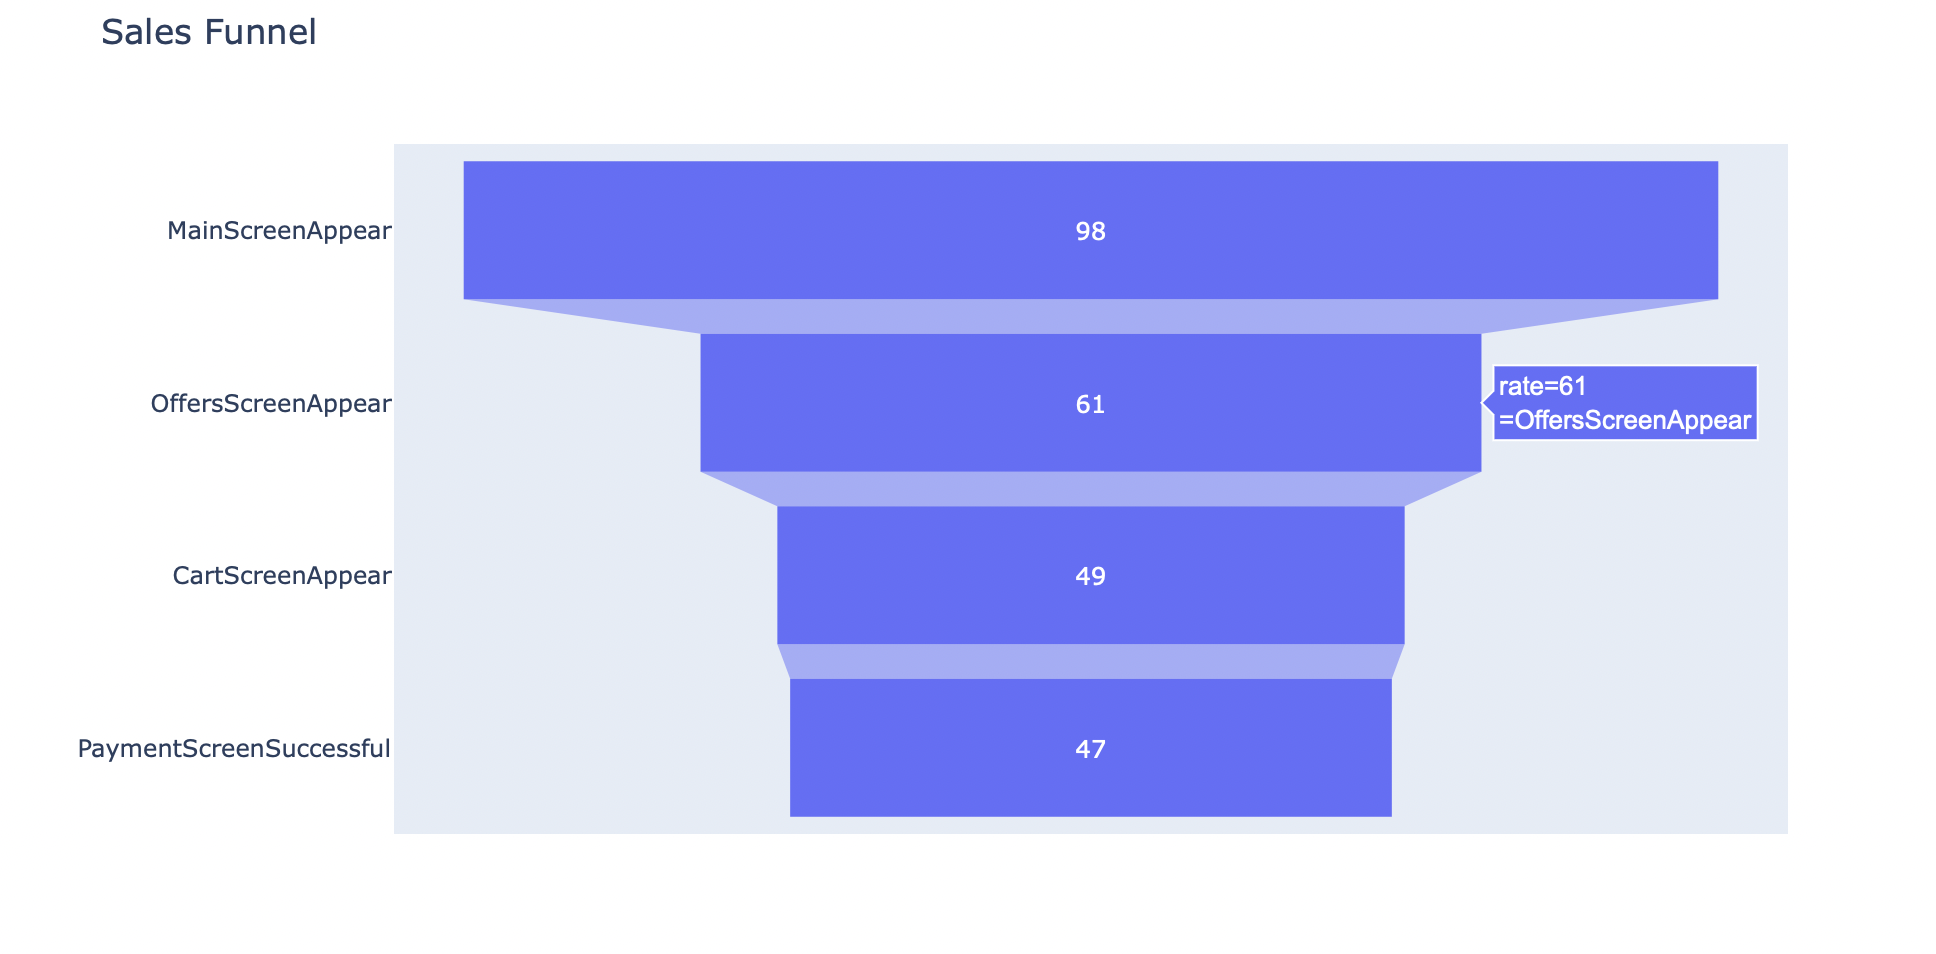

# Изучение результатов эксперимента
<a id="experiment"></a>

[К ОГЛАВЛЕНИЮ](#back_to_title)

Для начала посмотрим, сколько всего пользователей в каждой экспериментальной группе:

In [142]:
data_new_one=data_new.query('event_name!="Tutorial"') #создаем новый датасет, в котором отсутствует этап Tutorial


In [143]:
total = data_new_one.pivot_table(index='group',values='device_id', aggfunc='nunique').reset_index()
display(total)





,group,device_id
0,246,2483
1,247,2512
2,248,2535


Проверим, пересекаются ли пользователи в группах между собой:

In [187]:
# Проверим пользователей, которые могли участвовать в двух или нескольких группах одновременно:
data_new_one.groupby('device_id').agg({'group':'nunique'}).query('group > 1') 


,group
device_id,


Пользователи в группах не пересекаются

В рамках эксперимента есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверим, находят ли статистические критерии разницу между выборками 246 и 247.

Создадим функцию для расчета статистических критериев разницы: 

In [146]:

def func (successes1, successes2, trials1, trials2, alpha=0.05):
    p1 = successes1/trials1
    p2 = successes2/trials2
    p_combined = (successes1 + successes2) / (trials1 + trials2)
    difference = p1 - p2 
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))
    distr = stats.norm(0, 1)  
    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
       'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
        ) 
  

Нулевая гипотеза -  пропорций двух генеральных совокупностей равны. 

Выберем самое популярное событие. Это 'MainScreenAppear'. Посчитаем число пользователей, совершивших это событие в каждой из контрольных групп. 

In [147]:
main_screen = data_new_one.query('event_name=="MainScreenAppear"').pivot_table(index=['event_name'], values = 'device_id',columns=['group'], aggfunc='nunique')
main_screen = main_screen.reset_index()
main_screen.columns = ['event_name', 'a1','a2','b']
display(main_screen)

,event_name,a1,a2,b
0,MainScreenAppear,2450,2476,2493


Посчитаем долю пользователей, совершивших это событие.

In [148]:
main_246 = display(round(2450*100/2484))
main_247 = display(round(2476*100/2513))

99

99


Проверим, будет ли отличие между группами статистически достоверным. Проделаем то же самое для всех других событий (удобно обернуть проверку в отдельную функцию). Можно ли сказать, что разбиение на группы работает корректно?

In [149]:
funnel = (data_new_one.pivot_table(index='event_name', values = 'device_id',columns=['group'], aggfunc='nunique')).reset_index()
funnel.columns= ['event_name','a1','a2','b']
display(funnel)

,event_name,a1,a2,b
0,CartScreenAppear,1266,1238,1230
1,MainScreenAppear,2450,2476,2493
2,OffersScreenAppear,1542,1520,1531
3,PaymentScreenSuccessful,1200,1158,1181


In [150]:
#Проверим, будет ли отличие между группами по событию MainScreenAppear статистически достоверным

#func(2450, 2476, 2483, 2512)


successes1 = funnel.loc[1,"a1"] 
successes2 = funnel.loc[1,"a2"] 
trials1 = total.loc[0,'device_id']
trials2 = total.loc[1,'device_id']

func(successes1, successes2, trials1, trials2)

p-значение:  0.7526703436483038
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [151]:
#Проверим, будет ли отличие между группами по событию OffersScreenAppear статистически достоверным

#func(1542,1520, 2483, 2512)

successes1 = funnel.loc[2,"a1"] 
successes2 = funnel.loc[2,"a2"] 
trials1 = total.loc[0,'device_id']
trials2 = total.loc[1,'device_id']

func(successes1, successes2, trials1, trials2)

p-значение:  0.24786096925282264
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [152]:
#Проверим, будет ли отличие между группами по событию CartScreenAppear статистически достоверным

#func(1266, 1238, 2483, 2512)

successes1 = funnel.loc[0,"a1"] 
successes2 = funnel.loc[0,"a2"] 
trials1 = total.loc[0,'device_id']
trials2 = total.loc[1,'device_id']

func(successes1, successes2, trials1, trials2)


p-значение:  0.22867643757335676
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [153]:
#Проверим, будет ли отличие между группами по событию PaymentScreenSuccessful статистически достоверным

#func(1200, 1158, 2483, 2512)

successes1 = funnel.loc[3,"a1"] 
successes2 = funnel.loc[3,"a2"] 
trials1 = total.loc[0,'device_id']
trials2 = total.loc[1,'device_id']

func(successes1, successes2, trials1, trials2)

p-значение:  0.11446627829276612
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


По всем событиям для двух контрольных групп нет оснований считать доли этих событий разными. Таким образом, трафик выделен корректно, можно продолжать анализ данных и сравнивать группы А с группой B. 

Аналогично поступим с группой с изменённым шрифтом. Сравним результаты с каждой из контрольных групп в отдельности по каждому событию. Сравним результаты с объединённой контрольной группой. Посмотрим, какие выводы из эксперимента можно сделать.

В начале сравним контрольную группу 246 с экспериментальной группой 248.


In [154]:
#Проверим, будет ли отличие между группами по событию MainScreenAppear статистически достоверным

#func(2450, 2493, 2483, 2535)

successes1 = funnel.loc[1,"a1"] 
successes2 = funnel.loc[1,"b"] 
trials1 = total.loc[0,'device_id']
trials2 = total.loc[2,'device_id']

func(successes1, successes2, trials1, trials2)

p-значение:  0.3387114076159288
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [155]:
#Проверим, будет ли отличие между группами по событию OffersScreenAppear статистически достоверным

#func(1542, 1531, 2483, 2535)

successes1 = funnel.loc[2,"a1"] 
successes2 = funnel.loc[2,"b"] 
trials1 = total.loc[0,'device_id']
trials2 = total.loc[2,'device_id']

func(successes1, successes2, trials1, trials2)

p-значение:  0.21442476639710506
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [156]:
#Проверим, будет ли отличие между группами по событию CartScreenAppear статистически достоверным

#func(1266, 1230, 2483, 2535)

successes1 = funnel.loc[0,"a1"] 
successes2 = funnel.loc[0,"b"] 
trials1 = total.loc[0,'device_id']
trials2 = total.loc[2,'device_id']

func(successes1, successes2, trials1, trials2)

p-значение:  0.08067367598823139
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [157]:
#Проверим, будет ли отличие между группами по событию PaymentScreenSuccessful статистически достоверным

#func(1200, 1181, 2483, 2535)

successes1 = funnel.loc[3,"a1"] 
successes2 = funnel.loc[3,"b"] 
trials1 = total.loc[0,'device_id']
trials2 = total.loc[2,'device_id']

func(successes1, successes2, trials1, trials2)

p-значение:  0.21693033984516674
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Статистически значимой разницы между группами 246 и 248 не оказалось.

Теперь сравним контрольную группу 247 с экспериментальной группой 248

In [158]:
#Проверим, будет ли отличие между группами по событию MainScreenAppear статистически достоверным

#func(2476, 2493, 2512, 2535)

successes1 = funnel.loc[1,"a2"] 
successes2 = funnel.loc[1,"b"] 
trials1 = total.loc[1,'device_id']
trials2 = total.loc[2,'device_id']

func(successes1, successes2, trials1, trials2)

p-значение:  0.5194964354051703
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [159]:
#Проверим, будет ли отличие между группами по событию OffersScreenAppear статистически достоверным

#func(1520, 1531, 2512, 2535)

successes1 = funnel.loc[2,"a2"] 
successes2 = funnel.loc[2,"b"] 
trials1 = total.loc[1,'device_id']
trials2 = total.loc[2,'device_id']

func(successes1, successes2, trials1, trials2)

p-значение:  0.9333751305879443
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [160]:
#Проверим, будет ли отличие между группами по событию CartScreenAppear статистически достоверным

#func(1238, 1230, 2512, 2535)

successes1 = funnel.loc[0,"a2"] 
successes2 = funnel.loc[0,"b"] 
trials1 = total.loc[1,'device_id']
trials2 = total.loc[2,'device_id']

func(successes1, successes2, trials1, trials2)

p-значение:  0.5878284605111943
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [161]:
#Проверим, будет ли отличие между группами по событию PaymentScreenSuccessful статистически достоверным

#func(1158, 1181, 2512, 2535)

successes1 = funnel.loc[3,"a2"] 
successes2 = funnel.loc[3,"b"] 
trials1 = total.loc[1,'device_id']
trials2 = total.loc[2,'device_id']

func(successes1, successes2, trials1, trials2)

p-значение:  0.7275718682261119
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Статистически значимой разницы между группами 247 и 248 не оказалось. Сравним результаты с объединённой контрольной группой

In [162]:
funnel['a3']=funnel['a1']+funnel['a2'] #считаем сумму по двум контрольным группам в новой колонке
funnel

,event_name,a1,a2,b,a3
0,CartScreenAppear,1266,1238,1230,2504
1,MainScreenAppear,2450,2476,2493,4926
2,OffersScreenAppear,1542,1520,1531,3062
3,PaymentScreenSuccessful,1200,1158,1181,2358


In [163]:
#сумма уникальных айди пользователей в двух группах

total_a = data_new_one.query('group == 246 or group == 247')['device_id'].nunique()
display(total_a)

4995

In [164]:
#Проверим, будет ли отличие между группами по событию MainScreenAppear статистически достоверным

#func(4926, 2493, 4995, 2535)

successes1 = funnel.loc[1,"a3"] 
successes2 = funnel.loc[1,"b"] 
trials1 = total_a
trials2 = total.loc[2,'device_id']

func(successes1, successes2, trials1, trials2)

p-значение:  0.3486684291093256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [165]:
#Проверим, будет ли отличие между группами по событию OffersScreenAppear статистически достоверным

#func(3062, 1531, 4995, 2535)

successes1 = funnel.loc[2,"a3"] 
successes2 = funnel.loc[2,"b"] 
trials1 = total_a
trials2 = total.loc[2,'device_id']

func(successes1, successes2, trials1, trials2)

p-значение:  0.44582745409482394
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [166]:
#Проверим, будет ли отличие между группами по событию CartScreenAppear статистически достоверным

#func(2504, 1230, 4995, 2535)

successes1 = funnel.loc[0,"a3"] 
successes2 = funnel.loc[0,"b"] 
trials1 = total_a
trials2 = total.loc[2,'device_id']

func(successes1, successes2, trials1, trials2)

p-значение:  0.18683558686831558
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [167]:
#Проверим, будет ли отличие между группами по событию PaymentScreenSuccessful статистически достоверным

#func(2358, 1181, 4995, 2535)

successes1 = funnel.loc[3,"a3"] 
successes2 = funnel.loc[3,"b"] 
trials1 = total_a
trials2 = total.loc[2,'device_id']

func(successes1, successes2, trials1, trials2)

p-значение:  0.6107918742187335
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Статистически значимой разницы между объединенной контрольной группой и экспериментальной группой не оказалось. Таким образом, новые шрифты никак не влияют на конверсию пользователей на каждом этапе воронки. 

При проверке статистических гипотез выше был выбран уровент значимости 5%. Общее количество проверок статистических гипотез равно 1 (только однна экспериментальная группа с измененным шрифтом). При общем числе гипотез m = 1, FWER = ɑ, то есть 5%. Считаю возможным оставить текущий уровень значимости. 


# Выводы
<a id="summary"></a>

[К ОГЛАВЛЕНИЮ](#back_to_title)

**Предобработка данных**

В ходе предобработки данных были переименованы колонки, данные изучены на пропущенные значения и дубликаты. Пропущенных значений не выявлено. Дубликаты выявлены и удалены. Колонка 'event_date' преведена к типу данных datetime. Из этой же колонки извлечена отдельно дата и создана новая колонка, содержащая только дату (без времени).

Расчитано общее количество событий в логе (243713) и общее количество пользователей в логе (7551). На одного пользователя приходится в среднем 32 события. 

В датасете изначально охвачен период с 25 июля по 7 августа 2019 года. Была построена гистограмм с целью обнаружить период , данные за которые не являются полные. Такой период обнаружен - это данные до 1 августа.  В результате для дальнейшего анализа использовался период  с 1 по 7 августа 2019 года. Отбросив старые данные, мы потеряли 1,2% событий и 0,2% пользователей, что является вполне допустимым и не превышает 5%.

**Анализ воронки продаж**

Выявлены события, встречающиеся в логах (в порядке убывания встречаемости): 
 1) MainScreenAppear, 2) OffersScreenAppear , 3) CartScreenAppear, 4) PaymentScreenSuccessful, 5) Tutorial. 
 
События , указанные в предыдущем абзаце - это:
1) Появление главного экрана, 
2) Появление экрана с предложениями покупок, 3) Появление экрана с корзиной, 4) Экран с успешно выполненной оплатой, 5) Обучающие материалы по продукту. Если убрать пункт с Обучающими материалами, то получается логичная и последовательная воронка продаж. 

По воронке расчитано, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). Больше всего пользователей в процентных пунктах (38 пп) теряется на этапе перехода с первого шага воронки на второй, а именно с Главного экрана на Экран предложений. От первого события (главный экран) до оплаты доходит 48% пользователей. 

**Результаты А/А/B теста**


Проверили, является ли отличие между группами А и А статистически достоверным (по каждому событию воронки). Выявлено, что разбиение на группы работает корректно. По всем событиям для двух контрольных групп нет оснований считать доли этих событий разными. Таким образом, трафик выделен корректно. 

Далее сравнили результаты экспериментальной группы с каждой из контрольных групп в отдельности по каждому событию. Также сравнили результаты с объединённой контрольной группой. 

Статистически значимой разницы между 1) первой контрольной группой и экспериментальной группой, 2) второй контрольной группой и экспериментальной группой, 3) объединенной контрольной группой и экспериментальной группой **не оказалось**. 

Таким образом, новые шрифты никак не влияют на конверсию пользователей на каждом этапе воронки. 


[К ОГЛАВЛЕНИЮ](#back_to_title)